# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [2]:
# Ejemplo de optimizacion bayesiana, univariada

# limpio la memoria
rm(list = ls()) # remove all objects
gc() # garbage collection

require("data.table")
# paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width = 20, repr.plot.height = 10)


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,660819,35.3,1413187,75.5,1413187,75.5
Vcells,1226169,9.4,8388608,64.0,1815613,13.9


Loading required package: DiceKriging

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DiceKriging’”
Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate



### Defino la funcion a optimizar, un polinomio de grado 4

In [3]:
func_univariada01 <- function(x) {
  y <- -2 * (x + 13) * (x - 3) * (x - 7) * (x - 19)

  return(y)
}


Grafico la funcion

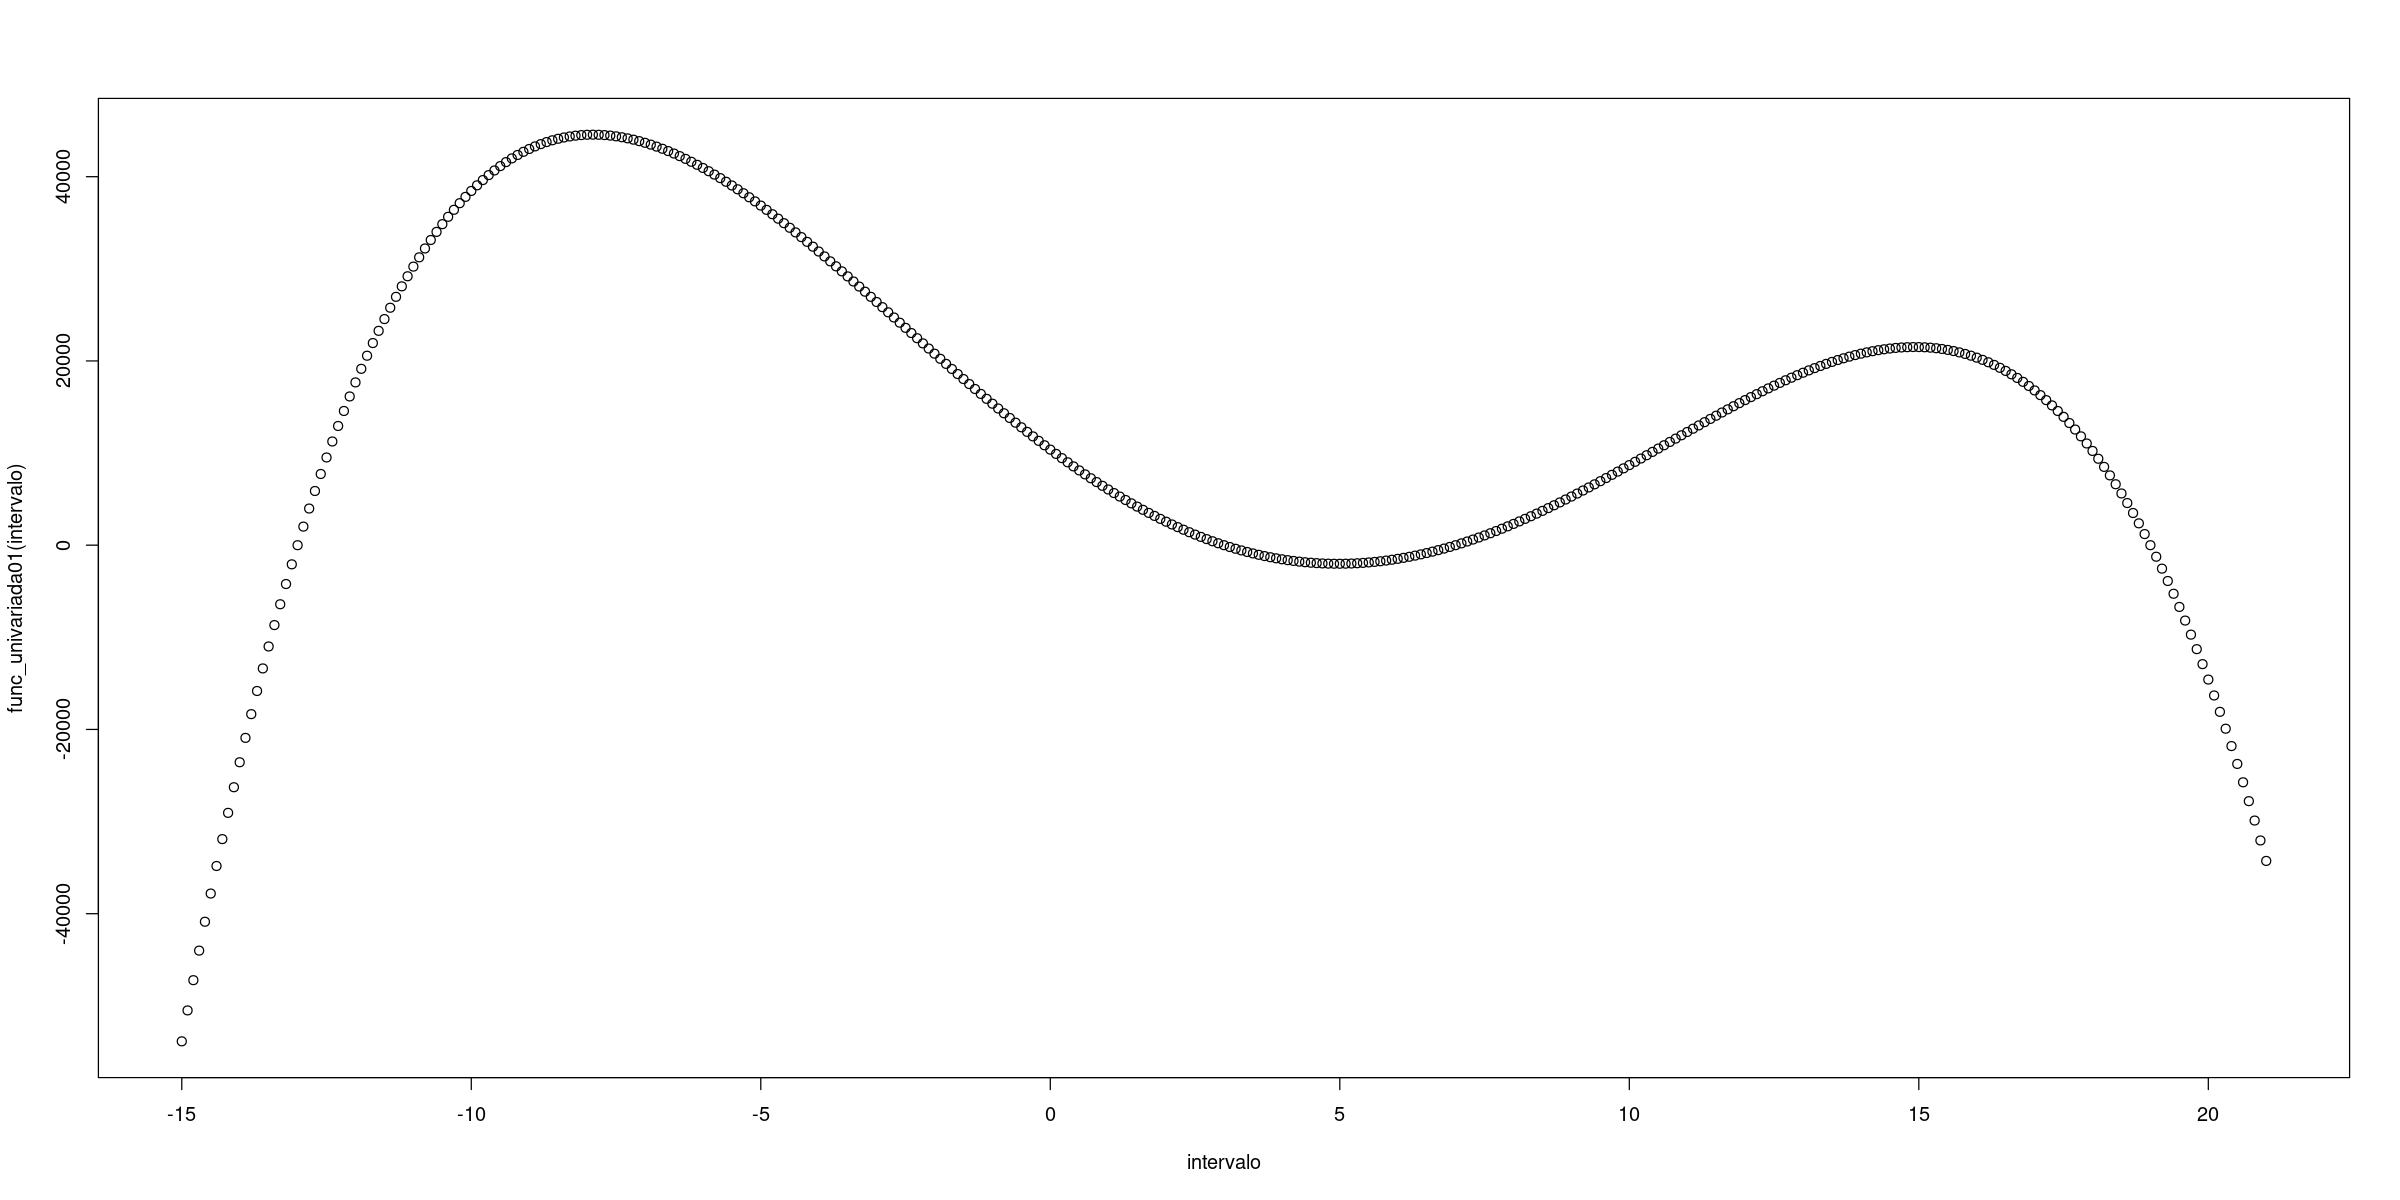

In [4]:
intervalo <- seq(-15, 21, 0.1)
plot(intervalo, func_univariada01(intervalo))


La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [5]:
obj.fun <- makeSingleObjectiveFunction(
    fn = func_univariada01,
    minimize = FALSE, # estoy Maximizando la ganancia
    par.set = makeParamSet(makeNumericParam("x", lower = -100, upper = 100)),
)


ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [7]:
fproxy <- makeLearner(
    cl = "regr.km",
    predict.type = "se",
    covtype = "matern3_2"
)


ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [8]:
ctrl <- makeMBOControl()
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())
ctrl <- setMBOControlTermination(ctrl, iters = 25)


finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [9]:
run <- mbo(
    fun = obj.fun,
    learner = fproxy,
    control = ctrl
)


Computing y column(s) for design. Not provided.

[mbo] 0: x=56.5 : y = -1.39e+07 : 0.0 secs : initdesign

[mbo] 0: x=40.9 : y = -3.03e+06 : 0.0 secs : initdesign

[mbo] 0: x=-61.5 : y = -3.45e+07 : 0.0 secs : initdesign

[mbo] 0: x=-11.7 : y = 2.26e+04 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -71.35522 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       71.355  |proj g|=    0.0010142
At iterate     1  f =       71.355  |proj g|=     0.0010142
At iterate     2  f =       71.354  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 71.3538

F = 71.3538
final  value 71.353845 
converged


[mbo] 1: x=-24.1 : y = -8.04e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -88.67203 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       88.672  |proj g|=     0.028844
At iterate     1  f =       88.671  |proj g|=      0.028741
At iterate     2  f =       88.545  |proj g|=     0.0044399
At iterate     3  f =       88.541  |proj g|=     0.0013591
At iterate     4  f =       88.541  |proj g|=    0.00011945
At iterate     5  f =       88.541  |proj g|=    3.6659e-06
At iterate     6  f =       88.541  |proj g|=    1.0342e-08

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 2: x=17.1 : y = 1.65e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -105.6497 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       105.65  |proj g|=     0.022266
At iterate     1  f =       105.65  |proj g|=      0.022206
At iterate     2  f =       105.54  |proj g|=     0.0053506
At iterate     3  f =       105.53  |proj g|=     0.0018621
At iterate     4  f =       105.53  |proj g|=    0.00027628
At iterate     5  f =       105.53  |proj g|=    1.7628e-05
At iterate     6  f =       105.53  |proj g|=    1.8237e-07

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 3: x=3.31 : y = -588 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -121.4838 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       121.48  |proj g|=     0.001266
At iterate     1  f =       121.48  |proj g|=     0.0012652
At iterate     2  f =       121.48  |proj g|=    7.9211e-05
At iterate     3  f =       121.48  |proj g|=    5.3633e-06
At iterate     4  f =       121.48  |proj g|=    2.4859e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.48586e-08
final function value 121.482

F = 121.482
final  value 121.482354 
conver

[mbo] 4: x=27.5 : y = -3.44e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -136.8865 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       136.89  |proj g|=    0.0018023
At iterate     1  f =       136.89  |proj g|=     0.0018016
At iterate     2  f =       136.88  |proj g|=    0.00018777
At iterate     3  f =       136.88  |proj g|=    2.2226e-05
At iterate     4  f =       136.88  |proj g|=    3.2088e-07
At iterate     5  f =       136.88  |proj g|=    5.5852e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 5.58525e-10
final functio

[mbo] 5: x=-17.5 : y = -1.65e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -151.4001 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        151.4  |proj g|=   0.00018811
At iterate     1  f =        151.4  |proj g|=    0.00018807

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.00018807
final function value 151.4

F = 151.4
final  value 151.400129 
converged


[mbo] 6: x=-4.21 : y = 3.3e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -165.7763 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       165.78  |proj g|=   2.4713e-05
At iterate     1  f =       165.78  |proj g|=     2.471e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.47098e-05
final function value 165.776

F = 165.776
final  value 165.776330 
converged


[mbo] 7: x=10.5 : y = 1.05e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -179.9285 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       179.93  |proj g|=   0.00059464
At iterate     1  f =       179.93  |proj g|=    0.00059457

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000594567
final function value 179.929

F = 179.929
final  value 179.928524 
converged


[mbo] 8: x=-7.94 : y = 4.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -193.1232 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       193.12  |proj g|=   0.00056664
At iterate     1  f =       193.12  |proj g|=    0.00056659

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000566589
final function value 193.123

F = 193.123
final  value 193.123234 
converged


[mbo] 9: x=21.4 : y = -4.28e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -206.7011 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        206.7  |proj g|=   4.4772e-05
At iterate     1  f =        206.7  |proj g|=    4.4769e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.47695e-05
final function value 206.701

F = 206.701
final  value 206.701125 
converged


[mbo] 10: x=-0.528 : y = 1.29e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -219.7255 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       219.73  |proj g|=   0.00042423
At iterate     1  f =       219.73  |proj g|=    0.00042421

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000424212
final function value 219.726

F = 219.726
final  value 219.725548 
converged


[mbo] 11: x=13.8 : y = 2.04e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -232.5207 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       232.52  |proj g|=   0.00015718
At iterate     1  f =       232.52  |proj g|=    0.00015718

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000157177
final function value 232.521

F = 232.521
final  value 232.520728 
converged


[mbo] 12: x=6.95 : y = -103 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -245.3189 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       245.32  |proj g|=   0.00061039
At iterate     1  f =       245.32  |proj g|=    0.00061036

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000610363
final function value 245.319

F = 245.319
final  value 245.318942 
converged


[mbo] 13: x=-9.7 : y = 4.02e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -257.2833 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       257.28  |proj g|=     0.002554
At iterate     1  f =       257.28  |proj g|=     0.0025538
At iterate     2  f =       257.24  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 257.236

F = 257.236
final  value 257.235716 
converged


[mbo] 14: x=-6.13 : y = 4.14e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -269.038 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       269.04  |proj g|=    0.0019077
At iterate     1  f =       269.04  |proj g|=     0.0019076
At iterate     2  f =       269.03  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 269.033

F = 269.033
final  value 269.033111 
converged


[mbo] 15: x=-2.46 : y = 2.34e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -280.851 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       280.85  |proj g|=    0.0037691
At iterate     1  f =       280.85  |proj g|=     0.0037688
At iterate     2  f =       280.79  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 280.792

F = 280.792
final  value 280.791748 
converged


[mbo] 16: x=19 : y = 228 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -292.948 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       292.95  |proj g|=    0.0058403
At iterate     1  f =       292.95  |proj g|=     0.0058397
At iterate     2  f =       292.81  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 292.807

F = 292.807
final  value 292.806834 
converged


[mbo] 17: x=-13.8 : y = -1.93e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -305.1211 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       305.12  |proj g|=    0.0045128
At iterate     1  f =       305.12  |proj g|=     0.0045124
At iterate     2  f =       305.09  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 305.091

F = 305.091
final  value 305.091348 
converged


[mbo] 18: x=15.4 : y = 2.13e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -316.7314 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       316.73  |proj g|=    0.0064708
At iterate     1  f =       316.73  |proj g|=     0.0064702
At iterate     2  f =       316.62  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 316.622

F = 316.622
final  value 316.621845 
converged


[mbo] 19: x=-7.08 : y = 4.38e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -327.316 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       327.32  |proj g|=    0.0060746
At iterate     1  f =       327.32  |proj g|=     0.0060741
At iterate     2  f =       327.28  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 327.277

F = 327.277
final  value 327.276895 
converged


[mbo] 20: x=1.36 : y = 4.69e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -339.1701 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       339.17  |proj g|=    0.0090298
At iterate     1  f =       339.17  |proj g|=     0.0090287
At iterate     2  f =       338.97  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 338.974

F = 338.974
final  value 338.973557 
converged


[mbo] 21: x=-8.79 : y = 4.36e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -349.6427 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       349.64  |proj g|=    0.0091094
At iterate     1  f =       349.64  |proj g|=     0.0091083
At iterate     2  f =       349.49  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 349.487

F = 349.487
final  value 349.486521 
converged


[mbo] 22: x=12.1 : y = 1.62e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -360.9894 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       360.99  |proj g|=    0.0087208
At iterate     1  f =       360.99  |proj g|=     0.0087198
At iterate     2  f =       360.91  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 360.913

F = 360.913
final  value 360.913459 
converged


[mbo] 23: x=-5.25 : y = 3.8e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -371.5406 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       371.54  |proj g|=    0.0090776
At iterate     1  f =       371.54  |proj g|=     0.0090765
At iterate     2  f =       371.49  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 371.493

F = 371.493
final  value 371.492856 
converged


[mbo] 24: x=8.73 : y = 4.42e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -383.3339 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       383.33  |proj g|=     0.013574
At iterate     1  f =       383.33  |proj g|=      0.013571
At iterate     2  f =       382.99  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 382.99

F = 382.99
final  value 382.989734 
converged


[mbo] 25: x=-10.5 : y = 3.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  236.0761 
  - best initial criterion value(s) :  -393.7162 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       393.72  |proj g|=     0.011949
At iterate     1  f =       393.72  |proj g|=      0.011947
At iterate     2  f =       393.55  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 393.553

F = 393.553
final  value 393.552917 
converged


In [10]:
tb_resultados <- as.data.table(run$opt.path)


In [11]:
tb_resultados


x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
56.5477471,-1.385677e+07,0,NA,NA,0.009,NA,NA,NA,initdesign,NA,NA,NA
40.8942878,-3.031125e+06,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-61.4903113,-3.447880e+07,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-11.6543901,2.255229e+04,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-24.0848123,-8.041862e+05,1,NA,NA,0.000,-1234798.563,NA,0.033,infill_ei,0.182,13517866.62,-1.283604e+07
17.0588568,1.650284e+04,2,NA,NA,0.001,-2697985.293,NA,0.022,infill_ei,0.164,11084095.08,-4.001934e+06
3.3112748,-5.876595e+02,3,NA,NA,0.000,-1389118.329,NA,0.014,infill_ei,0.118,4094505.39,-4.919074e+05
27.4733673,-3.436674e+05,4,NA,NA,0.001,-880197.488,NA,0.011,infill_ei,0.122,2138856.24,7.585695e+04
-17.4931638,-1.646068e+05,5,NA,NA,0.000,-401228.626,NA,0.012,infill_ei,0.161,775167.56,1.918268e+05


In [12]:
tb_resultados[which.max(tb_resultados$y)]


x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.939324,44560.15,8,NA,NA,0,-100717.6,NA,0.018,infill_ei,0.134,226222.4,53203.69


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?